<a href="https://colab.research.google.com/github/pyqt555/cudaFieldLines/blob/master/interface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
#@title Setup
import numpy as np
import numba
from numba import float64
import math
import time
import cv2 as cv2
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb as rgb
import os
try:
    from google.colab.patches import cv2_imshow
except:
    print("Not running on Colab, if errors occur replace cv2_imshow with cv2.imshow()")
from joblib import Parallel, delayed
from multiprocessing.dummy import Pool as ThreadPool
import itertools

X=0
Y=1
C=2
Step_length=35.93 #@param {type:"slider",min:0.01,max:100,step:0.01}
TIMESCALE=Step_length
#@markdown Distance of steps in the simulation, increase to  increase speed/decrease accuracy of the simulation.
UseE0 =False #@param {type:"boolean"}
if UseE0:
  E0=8.8541878128*(10**(-12))
else:
  E0=1
#@markdown Option to use E0 for realistic Computation, not recommended since extreme number often leads to inaccurate/slow computations.
@numba.guvectorize([(float64[:],float64[:],float64[:])], '(n),(n)->(n)',target="parallel")
def compute_force_guv(c1,c2,res):
    c_dir=c1[C]*c2[C]
    dist=((c1[X]-c2[X])**2+(c1[Y]-c2[Y])**2)**.5
    dir_vec=[c1[X]-c2[X],c1[Y]-c2[Y]]
    dir_len=dist
    norm_vec=[dir_vec[X]/dir_len,dir_vec[Y]/dir_len]
    return_const=(1/(4*math.pi*(dist**2)*E0))*TIMESCALE*c_dir*(-1)#-1 for correct direction
    res[:]=[norm_vec[X]*return_const,norm_vec[Y]*return_const,0]


@numba.jit
def compute_vectors_guv_fixed_output(non_statics,statics):
    f=compute_force_guv(non_statics,statics,np.zeros((statics.shape[0],3)))[:,:2]
    return np.array([np.sum(f[:,0]),np.sum(f[:,1])])
#@numba.jit
def compute_line(testcharge,line_length,statics):
  #print("new Charge")
  positions=[]
  for i in range(int(line_length)):
        #if i%100==0:
        #  print(i)
        testcharge_dir=compute_vectors_guv_fixed_output([testcharge],statics)
        
        testcharge=[testcharge[X]+testcharge_dir[X],testcharge[Y]+testcharge_dir[Y],testcharge[C]]
        
        if (testcharge_dir[X]**2+testcharge_dir[Y]**2) >(1*TIMESCALE)**2:
          #print(i)
          #print(np.sum(testcharge_dir**2))
          break
   
        positions.append(testcharge)
  #print("computed")
  return positions

def compute_lines(statics,nonstatics,line_length=1000):
    nonstatics=nonstatics.copy()
    positions=[]
    pool = ThreadPool(int((nonstatics.shape[0]/2)+0.999))
    print(nonstatics.shape[0])
    results = pool.starmap(compute_line, zip(nonstatics,itertools.repeat(line_length),itertools.repeat(statics)))
    pool.close()
    pool.join()
    #results=compute_line(nonstatics[0],line_length,statics)
    return np.array(results)

def extract_charges(img,val_img=None):
  img=cv2.cvtColor(img.copy(),cv2.COLOR_BGR2HSV)
  
  if type(val_img)!=type(None):
    valarray=cv2.cvtColor(val_img.copy(),cv2.COLOR_BGR2GRAY)/255
  else:
    valarray=np.ones(img[:,:,0].shape)
   
  bluemask=cv2.inRange(img, (80,125,125), (130,255,255))
  redmaskimg=img
  redmaskimg[:,:,0]+=75
  redmaskimg[:,:,0]=redmaskimg[:,:,0]%180
  redmask=cv2.inRange(redmaskimg,(65,125,125),(85,255,255))
  #cv2_imshow(redmask)
  #cv2_imshow(bluemask)
  #pos_charge_img=redmask*valarray
  #neg_charge_img=redmask*valarray*(-1)
  charges=[]
  neg_c=np.array(np.where(bluemask!=0))
  for i in range(neg_c.shape[1]):
    coords=neg_c[:,i]
    charges.append([coords[1],bluemask.shape[0]-coords[0]-1,valarray[coords[0],coords[1]]*-1])
  pos_c=np.array(np.where(redmask!=0))
  for i in range(neg_c.shape[1]):
    coords=pos_c[:,i]
    charges.append([coords[1],bluemask.shape[0]-coords[0]-1,valarray[coords[0],coords[1]]])
  return np.array(charges)

def distribute_line_charges(img,res_x,res_y=None):
  if type(res_y)==type(None):
    res_y=res_x
  
  x_coords=((np.arange(res_x)+.5)/res_x)*img.shape[1]
  y_coords=((np.arange(res_y)+.5)/res_y)*img.shape[0]
  lines=np.array(np.meshgrid(x_coords,y_coords,(-1,1))).T.reshape(-1,3)
  return lines

In [16]:
#@title Display Files
print(os.listdir())

['.config', 'test.png', 'sample_data']


In [67]:
#@title Load Image
Filename = "test.png" #@param {type:"string"}
image=cv2.imread(Filename)
#@markdown Upload an Image you created for example using Microsoft Paint where positive charges are represented by the colour red and negative charges by the colour blue.Then put the Filename of that image in the box above. 
Use_Value_Image = True #@param {type:"boolean"}
#@markdown If you dont want all of the charges to have the same Value, you can tick this box, and upload a grayscaled version of the above image under a different name. The brighter a pixel in this image is, the higher will the value of the charge (specified in the above image if there is any) be.
if Use_Value_Image:
  Val_Filename = "test.png" #@param {type:"string"}
  #@markdown Ignore if above box is unchecked, else is the filename of said image
  val_image=cv2.imread(Val_Filename)
else:
  pass

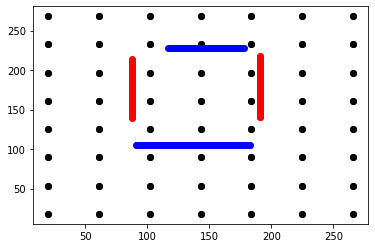

In [68]:
#@title Load Charges from Image

Scale = 28 #@param {type:"slider", min:0, max:200, step:1}
#@markdown Scaling input image(s) down for speed
width = int(image.shape[1] * Scale / 100)
height = int(image.shape[0] * Scale / 100)
dim = (width, height)
img = cv2.resize(image.copy(), dim, interpolation = cv2.INTER_AREA)
if Use_Value_Image:
  val_image=cv2.resize(val_image.copy(), dim, interpolation = cv2.INTER_AREA)
else:
  val_image=None
stationary_charges=extract_charges(img.copy(),val_image)
#@markdown Distributing Lines (Imagine as x and y Resolution of a Grid, where a Line is started at every intersection)
lines_x = 7 #@param {type:"integer"}
lines_y = 8 #@param {type:"integer"}
line_charges=distribute_line_charges(img.copy(),lines_x,lines_y)
for line_charge in line_charges:
  
  plt.plot(line_charge[0], line_charge[1],"o" ,color=rgb((1,1.,0.)))
for stat_charge in stationary_charges:
  if stat_charge[2]>0:
    h=1
  else:
    h=2/3
  plt.plot(stat_charge[0], stat_charge[1],"o" ,color=rgb((h,1.,1.)))
plt.show()

In [79]:
#@title Compute Lines
Line_length = 1107 #@param {type:"slider", min:10, max:10000, step:1}
lines=np.array(compute_lines(stationary_charges,line_charges,Line_length))

112


<ipython-input-78-d70b48c7f778>:42: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "compute_vectors_guv_fixed_output" failed type inference due to: Untyped global name 'compute_force_guv': Cannot determine Numba type of <class 'numpy.ufunc'>

File "<ipython-input-78-d70b48c7f778>", line 44:
def compute_vectors_guv_fixed_output(non_statics,statics):
    f=compute_force_guv(non_statics,statics,np.zeros((statics.shape[0],3)))[:,:2]
    ^

  @numba.jit
/usr/local/lib/python3.7/dist-packages/numba/core/object_mode_passes.py:152: NumbaWarning: Function "compute_vectors_guv_fixed_output" was compiled in object mode without forceobj=True.

File "<ipython-input-78-d70b48c7f778>", line 43:
@numba.jit
def compute_vectors_guv_fixed_output(non_statics,statics):
^

  state.func_ir.loc))
/usr/local/lib/python3.7/dist-packages/numba/core/object_mode_passes.py:162: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object m

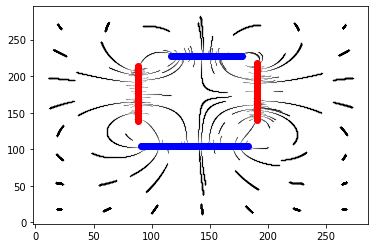

In [84]:
#@title Display Lines 
displayType = "circle" #@param ["pixel", "line", "circle"]
Circle_size = 0.036 #@param {type:"slider", min:0, max:2, step:0.001}
Line_width = 0.7 #@param {type:"slider", min:0, max:2, step:0.001}
if displayType=="pixel":
  for line in lines:
    if len(line)>0:
      nl=[]
      for el in line:
        if not (el[0]>img.shape[0]or el[1]>img.shape[1]or el[0]<0 or el[1]<0):
          nl.append([el[0],el[1]])
      nl=np.array(nl)
      #print(nl)
     
      plt.plot(nl[:,0], nl[:,1],",",color="black")
elif displayType=="circle":
  for line in lines:
    if len(line)>0:
      nl=[]
      for el in line:
        if not (el[0]>img.shape[0]or el[1]>img.shape[1]or el[0]<0 or el[1]<0):
          nl.append([el[0],el[1]])
      nl=np.array(nl)
      #print(nl)
     
      plt.plot(nl[:,0], nl[:,1],"o",color="black",markersize=Circle_size)
elif displayType=="line":
  for line in lines:
    if len(line)>0:
      nl=[]
      for el in line:
        if not (el[0]>img.shape[0]or el[1]>img.shape[1]or el[0]<0 or el[1]<0):
          nl.append([el[0],el[1]])
      nl=np.array(nl)
      #print(nl)
     
      plt.plot(nl[:,0], nl[:,1],color="black",linestyle='-', linewidth=Line_width)
for stat_charge in stationary_charges:
  if stat_charge[2]>0:
    h=1
  else:
    h=2/3
  plt.plot(stat_charge[0], stat_charge[1],"o" ,color=rgb((h,1.,1.)))
plt.show()
      



